In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [123]:
df = pd.read_csv("penguins.csv")
df = df.dropna()             # Delete missing data
df = df.drop("sex", axis=1)  # Dropping sex because we want K means clustering and not K mode clustering

df.boxplot()
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


Dropping outliers (see boxplot)

In [124]:
df = df.drop(df[df["flipper_length_mm"] > 1000].index)
df = df.drop(df[df["flipper_length_mm"] < 0].index)
df.boxplot()

<Axes: >

In [125]:
# Min Max Scaling

df = ( (df - df.min()) / (df.max() - df.min()) ) * 9 + 1

df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,3.290909,7.000000,2.372881,3.625
1,3.421818,5.607143,3.135593,3.750
2,3.683636,6.250000,4.508475,2.375
4,2.505455,7.642857,4.203390,2.875
5,3.356364,9.035714,3.745763,3.375


# STEP 1
    Pick k random centroids for the k clusters (picking k random rows)

In [126]:
def init_random_cluster_centroids(df, k):
    return df.sample(n=k).reset_index(drop=True).T

# STEP 2
    Calculate euclidean distance from the data points to the centroids of the clusters

In [127]:
def get_cluster_label(df, cluster_centroid):
    distances = cluster_centroid.apply(lambda x: np.sqrt(np.square(df - x).sum(axis=1)) )  # Euclidean distance
    distances = distances.idxmin(axis=1)
    return distances

# STEP 3
    Update centroids of clusters based on the assigned data points to those clusters (Geometric mean)

In [128]:
def new_cluster_centroid(df, cluster_label):
    return df.groupby(cluster_label).apply(lambda x: np.exp(np.log(x).mean())).T

# STEP 4
    Repeat until centroids don't change anymore or max iterations is reached

In [129]:
iterations = 100
cluster_count = 5 # k
old_cluster_centroids = pd.DataFrame()
current_cluster_centroids = init_random_cluster_centroids(df, cluster_count)


while iterations > 0 and not current_cluster_centroids.equals(old_cluster_centroids):
    old_cluster_centroids = current_cluster_centroids

    cluster_labels = get_cluster_label(df, current_cluster_centroids)
    current_cluster_centroids = new_cluster_centroid(df, cluster_labels)
    iterations -= 1

current_cluster_centroids

,0,1,2,3,4
culmen_length_mm,2.801807,6.571642,5.308777,6.642367,3.470804
culmen_depth_mm,5.512701,6.769745,2.133129,3.699279,7.416110
flipper_length_mm,3.116040,4.744888,7.169385,8.497041,4.040455
body_mass_g,2.514486,3.618049,5.875615,7.898788,4.165939


# Elbow method to find the best k

In [130]:
def wcss_method(df, cluster_centroid): # With-in sum of squares
    distances = cluster_centroid.apply(lambda x: np.sqrt(np.square(df - x).sum(axis=1)))
    distances = distances.min(axis=1)
    print(np.sum(distances.values))
    return np.sum(distances.values)
    

1302.6441128646197
769.902199718378
654.1716625194651
589.5186676748916
555.9881308545641
550.1987208839045
542.3511624900038
476.3624523252473
437.42697978025893
425.25135679082564


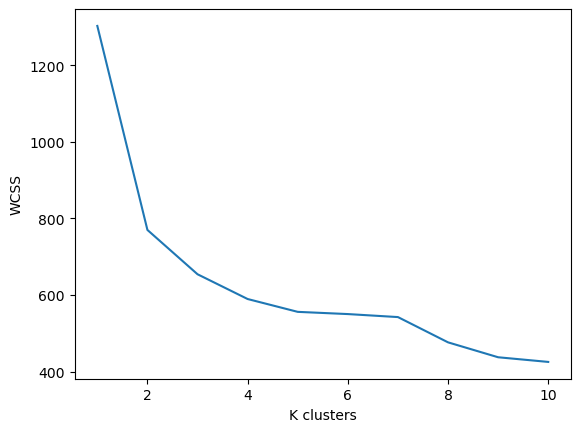

In [131]:
plt.clf()

def find_best_k(max_k):  # Elbow method
    wcss_list = []
    current_k = 1
    
    while(current_k <= max_k):
        current_cluster_centroids = init_random_cluster_centroids(df, current_k)
        old_cluster_centroids = pd.DataFrame()

        while(not current_cluster_centroids.equals(old_cluster_centroids)):
            old_cluster_centroids = current_cluster_centroids
            cluster_labels = get_cluster_label(df, current_cluster_centroids)
            current_cluster_centroids = new_cluster_centroid(df, cluster_labels)

        wcss_list.append(wcss_method(df, current_cluster_centroids))
        current_k+=1

    plt.plot(np.arange(1, max_k+1), wcss_list)

find_best_k(10)
plt.xlabel("K clusters")
plt.ylabel("WCSS")
plt.show()

[5387.802270188035, 2087.4622502107813, 1781.010380707642, 1216.969684169598, 912.8294643030629, 837.840089726029, 771.1210926908337, 661.4957641556049, 627.9092879548324]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

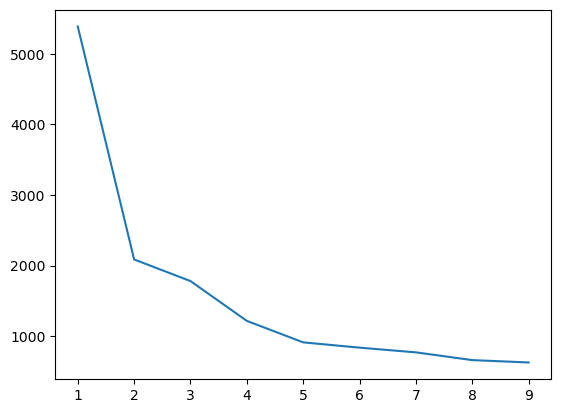

In [132]:
sklearn_wcss_list = []
for i in range(1, 10):
    kMeans = KMeans(n_clusters=i, init="k-means++")
    kMeans.fit(df)
    sklearn_wcss_list.append(kMeans.inertia_)

print(sklearn_wcss_list)
plt.plot(np.arange(1, 10), sklearn_wcss_list)
plt.show()